# **Trabalho de Extração**
##### **Autores:** Cátia Rosário (pg57791), Vanessa Rodriguez (pg49131), André Dias (pg55127)
##### **Data**: 2025-06-13



# Introdução

Esta análise visa investigar um conjunto de compostos químicos com base nos seus descritores moleculares e respetiva atividade mutagénica, conforme avaliada pelo teste de Ames. Após o pré-processamento dos dados — que incluiu a remoção de variáveis constantes e a normalização dos descritores restantes — procedeu-se à sumarização do conjunto de dados através de estatísticas descritivas e visualizações, com foco em compreender a distribuição das variáveis e a relação entre os descritores e a variável alvo.

De seguida, foram realizadas análises estatísticas multivariadas, incluindo redução de dimensionalidade - como PCA, UMAP e t-SNE - e métodos de clustering não supervisionado - como o K-Means, para investigar padrões latentes nos dados.

Adicionalmente, foram identificadas as variáveis mais informativas para a classificação mutagénica e realizada uma visualização estrutural das moléculas com o auxílio da biblioteca RDKit, permitindo uma análise química mais interpretável dos compostos centrais de cada grupo.

Este pipeline visa oferecer uma visão abrangente dos fatores estruturais associados à mutagenicidade e pode servir como base para futuras aplicações em toxicologia preditiva e química computacional.


## Dataset AMES
208 descritores moleculares numéricos no ficheiro ames_features.csv, calculados a partir de representações moleculares (SMILES).
Ficheiro de saídas ames_outputs.csv com identificador do composto (ids), representação química da estrutura (smiles) e variável alvo binária (0 ou 1) representando se a molécula é mutagênica ou não segundo o teste de Ames (Y).


## 1. Carregamento e Pré-processamento dos Dados

### 1.0 Carregamento de Bibliotecas

In [ ]:
!pip install rdkit

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import silhouette_samples
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold



### 1.1 Carregamento dos dados

In [ ]:
# Carregue os ficheiros CSV
features_df = pd.read_csv("C:\\Users\\UTILIZADOR\\Desktop\\2º trabalho EXT\\ames_features.csv")
outputs_df = pd.read_csv("C:\\Users\\UTILIZADOR\\Desktop\\2º trabalho EXT\\ames_outputs.csv")

In [ ]:
# Exibir as primeiras 5 linhas de features_df com estilo simples
display(features_df.head().style
        .set_table_styles([{
            'selector': 'th',
            'props': [('background-color', 'lightsteelblue'),
                      ('color', '#333'),
                      ('font-weight', 'bold'),
                      ('font-size', '14px')]
        }])
        .set_properties(**{'text-align': 'center', 'font-size': '12px'}))

# Exibir as primeiras 5 linhas de outputs_df com o mesmo estilo
display(outputs_df.head().style
        .set_table_styles([{
            'selector': 'th',
            'props': [('background-color', 'lightsteelblue'),
                      ('color', '#333'),
                      ('font-weight', 'bold'),
                      ('font-size', '14px')]
        }])
        .set_properties(**{'text-align': 'center', 'font-size': '12px'}))


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,11.663401,-0.396099,11.663401,0.008895,0.181963,342.310000,332.230000,342.064060,124.000000,0.000000,0.277383,-0.258290,0.277383,0.258290,0.538462,0.923077,1.307692,16.631770,9.878024,2.243219,-2.142638,2.460575,-1.957799,6.364064,-0.382738,2.267149,1284.790200,17.999271,13.300923,13.300923,12.575387,7.986911,7.986911,6.240968,6.240968,4.982737,4.982737,3.980293,3.980293,-3.800000,1358227.900000,14.535237,4.857510,1.699174,145.443040,0.000000,0.000000,0.000000,0.000000,11.374773,0.000000,20.228636,0.000000,0.000000,0.000000,36.398200,33.677630,22.905182,20.619070,9.846622,54.464565,0.000000,0.000000,0.000000,0.000000,0.000000,80.892300,0.000000,0.000000,0.000000,11.374773,0.000000,0.000000,9.846622,0.000000,20.228636,0.000000,60.663670,0.000000,43.089794,0.000000,86.280000,9.846622,20.228636,0.000000,11.374773,32.317345,10.772449,12.132734,36.398200,12.132734,0.000000,0.000000,0.000000,0.000000,22.534605,28.751337,0.017789,0.000000,17.362938,0.000000,0.000000,0.000000,0.000000,26.000000,0.000000,6.000000,0.000000,0.000000,0.000000,5.000000,0.000000,5.000000,4.000000,0.000000,6.000000,2.000000,0.000000,0.000000,0.000000,5.000000,5.553600,100.960800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.

,ids,smiles,Y
0,Drug 0,O=[N+]([O-])c1ccc2ccc3ccc([N+](=O)[O-])c4c5ccccc5c1c2c34,1
1,Drug 1,O=[N+]([O-])c1c2c(c3ccc4cccc5ccc1c3c45)CCCC2,1
2,Drug 2,O=c1c2ccccc2c(=O)c2c1ccc1c2[nH]c2c3c(=O)c4ccccc4c(=O)c3c3[nH]c4c(ccc5c(=O)c6ccccc6c(=O)c54)c3c12,0
3,Drug 3,[N-]=[N+]=CC(=O)NCC(=O)NN,1
4,Drug 4,[N-]=[N+]=C1C=NC(=O)NC1=O,1


**1. ames_features.csv**

Contém 208 descritores moleculares numéricos extraídos a partir da representação SMILES das moléculas. Esses descritores incluem:

    - Propriedades físico-químicas básicas (ex: peso molecular, logP, número de átomos).
    - Descritores topológicos (como Chi, Kappa, índice de conectividade).
    - Descritores eletrónicos (ex: cargas parciais, polarizabilidade).
    - Descritores 2D BCUT (Burden-CAS University of Texas).
    - Propriedades estruturais (ex: número de anéis aromáticos, átomos pesados, ligações duplas).
    - Descritores de superfície (como TPSA e ASA).

**Formato:**

    Linhas: compostos químicos
    Colunas: descritores
    Indexado por ids

**2. ames_outputs.csv**

Contém as informações de saída para cada molécula:

    ids: Identificador único da molécula
    smiles: Representação simplificada da estrutura química
    Y: Variável alvo binária (1 = mutagénico, 0 = não mutagénico), baseada no teste de Ames, um ensaio biológico padrão para avaliação de mutagenicidade.

**Importância da variável Y:**

    - Usada para modelagem preditiva (classificação binária)
    - Pode refletir mecanismos estruturais associados à toxicidade genética

### 1.2 Pré-Processamento

#### 1.2.1 Verificação e tratamento de valores ausentes

In [ ]:
# Dimensões dos datasets
print("Features:", features_df.shape)
print("Outputs:", outputs_df.shape)

Features: (7273, 208)
Outputs: (7273, 3)


In [ ]:
# Verificar tipos e valores ausentes
print(features_df.info())
print(outputs_df.info())

print("Valores ausentes em features:", features_df.isnull().sum().sum())
print("Valores ausentes em outputs:", outputs_df.isnull().sum().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7273 entries, 0 to 7272
Columns: 208 entries, MaxEStateIndex to fr_urea
dtypes: float64(208)
memory usage: 11.5 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7273 entries, 0 to 7272
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ids     7273 non-null   object
 1   smiles  7273 non-null   object
 2   Y       7273 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 170.6+ KB
None
Valores ausentes em features: 0
Valores ausentes em outputs: 0


#### 1.2.2 Remoção de colunas constantes ou nulas

In [ ]:
features_clean = features_df.drop(columns=['SMR_VSA8', 'SlogP_VSA9', 'fr_prisulfonamd'])

 #### 1.2.3 Normalização dos dados

In [ ]:
# Normalizar os dados
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_clean)

# Opcional: transformar de volta em DataFrame
features_scaled_df = pd.DataFrame(features_clean, columns=features_clean.columns)

## 2. Sumarização e Exploração dos Dados

### 2.1 Estatísticas Descritivas dos Descritores

In [ ]:
desc_stats = features_clean.describe()

desc_stats.style\
    .set_properties(**{
        'font-family': 'Arial',
        'font-size': '9pt',
        'text-align': 'center'
    })\
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightsteelblue'),
                                     ('color', 'black'),
                                     ('font-weight', 'bold'),
                                     ('border', '1px solid #ccc')]}
    ])\
    .set_caption("Estatísticas Descritivas das Features")


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,

Nesta tabela podemos observar as estatísticas descritivas - contagem, média, desvio-padrão, quartis e mínimos e máximos - para cada feature após retirar colunas nulas.

**Amostragem Consistente:**
- Todas as variáveis apresentadas possuem 7273 observações, o que indica que não há dados em falta neste subconjunto após a limpeza inicial

**Distribuição de Valores:**
- Para a maioria dos descritores, é possível observar uma variação significativa nos valores mínimos e máximos, o que indica heterogeneidade nas propriedades moleculares

- Certas features podem assumir valores negativos, sugerindo descritores com propriedades eletrónicas direcionais

**Amplitude e Assimetria:**
- A diferença entre os quartis e os valores extremos (mínimo e máximo) sugere que algumas variáveis podem apresentar distribuições assimétricas ou presença de outliers

**Escalas Diversas:**
- Os descritores estão em escalas muito diferentes, com alguns variando em intervalos pequenos - normalização necessária antes de ML

In [ ]:
desc_scaled = features_scaled_df.describe()

desc_scaled.style\
    .set_properties(**{
        'font-family': 'Arial',
        'font-size': '9pt',
        'text-align': 'center'
    })\
    .set_table_styles([
        {'selector': 'th', 'props': [('background-color', 'lightsteelblue'),
                                     ('color', 'black'),
                                     ('font-weight', 'bold'),
                                     ('border', '1px solid #ccc')]}
    ])\
    .set_caption("Estatísticas Descritivas das Features")

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BCUT2D_MWHI,BCUT2D_MWLOW,BCUT2D_CHGHI,BCUT2D_CHGLO,BCUT2D_LOGPHI,BCUT2D_LOGPLOW,BCUT2D_MRHI,BCUT2D_MRLOW,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,7273.000000,

Nesta tabela podemos observar as estatísticas descritivas - contagem, média, desvio-padrão, quartis e mínimos e máximos - para cada feature após o escalonamento.

**Amostragem Consistente:**
- Todas as variáveis apresentadas possuem 7273 observações, o que confirma a consitência do conjunto de dados após o pré-processamento e escalonamento. Não há dados ausentes

**Distribuição de Valores:**
- O escalonamento reduziu as diferenças entre escalas. A média de muitas variavéis está prózima de zero e o desvio padrão tende a 1, o que é típico de técnicas como padronização Z-score sendo que isto permite que algoritmos de aprendizado de máquina tratem todas as variáveis de forma equitativa

**Amplitude e Assimetria:**
- Apesar da padronização, ainda é possívl observar valores máximos e mínimos distantes, indicando que algumas variáveis mantêm distribuições assimétricas ou a presença de outliers, o que já esperado visto que o escolamento não remove outliers, apenas ajusta a escala

**Escalas Uniformizadas:**
- A padronização garantiu que as features estejam em escalas comparáveis, o que é fundamental para algoritmos sensíveis à escala, como por exemplo a média das variavéis como MolWt, TPSA, NumHA, entre outras, foi centrada em torno de zero e o desvio padrão está próximo de 1, evidenciando que a transformação foi bem-sucedida.

### 2.1 Análise da variável alvo

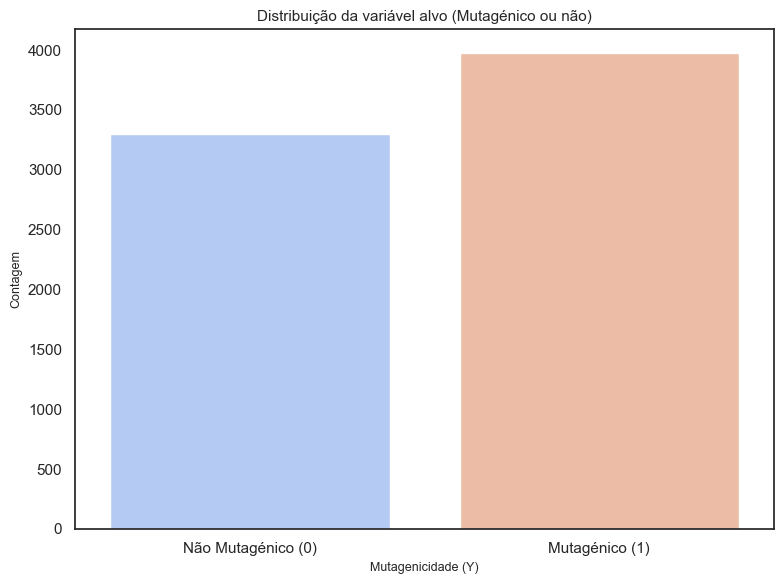

In [ ]:
plt.figure(figsize=(8, 6))
sns.set(style="white")
sns.countplot(x='Y', data=outputs_df, palette='coolwarm')
plt.title('Distribuição da variável alvo (Mutagénico ou não)', fontsize=11)
plt.xlabel('Mutagenicidade (Y)', fontsize=9)
plt.ylabel('Contagem', fontsize=9)
plt.xticks(ticks=[0, 1], labels=['Não Mutagénico (0)', 'Mutagénico (1)'])
plt.tight_layout()
plt.show()

O gráfico de barras gerado com a biblioteca Seaborn em Python. Analisa a variável alvo "Y", indicando se uma substância é mutagénica ou não. Uma das barras representa os casos não mutagénicos ("Não Mutagénico (0)") e a outra os casos mutagénicos ("Mutagénico (1)"). O gráfico sugere que há mais instâncias mutagénicas do que não mutagénicas no conjunto de dados.

### 2.2 Visualização de descritores moleculares





#### 2.2.1 Análise das primeiras 6 variáveis - Histogramas

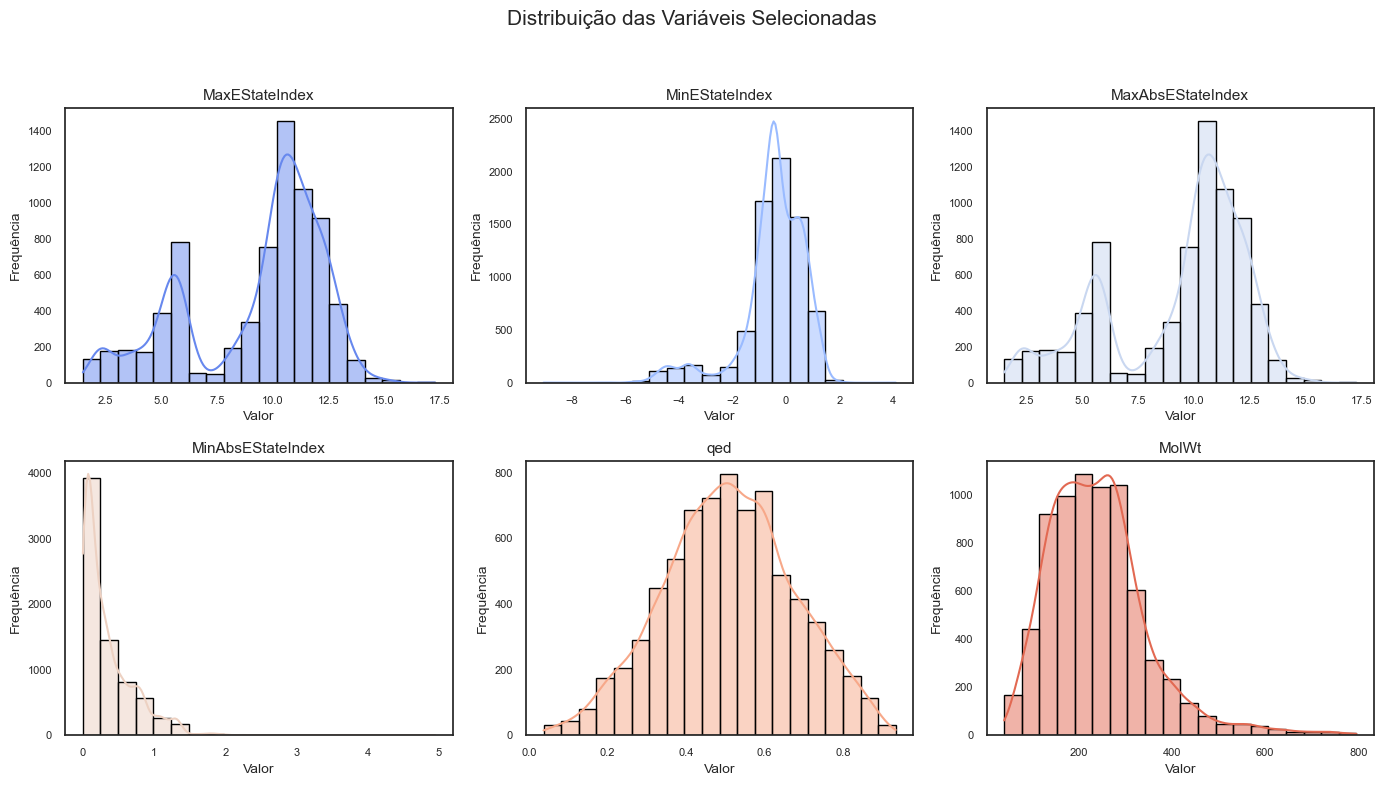

In [ ]:
# Selecionar as primeiras 6 variáveis
selected_features = features_clean.columns[:6]

# Estilo limpo
sns.set(style="whitegrid")

# Cores da paleta coolwarm (alternância entre elas)
colors = sns.color_palette("coolwarm", len(selected_features))
sns.set(style="white")
# Criar histogramas 3x2
plt.figure(figsize=(14, 8))
for i, feature in enumerate(selected_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(features_clean[feature], kde=True, bins=20, color=colors[i], edgecolor='black')
    plt.title(feature, fontsize=11)
    plt.xlabel('Valor', fontsize=10)
    plt.ylabel('Frequência', fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

plt.suptitle('Distribuição das Variáveis Selecionadas', fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Os histogramas apresentados refletem a distribuição de seis variáveis selecionadas no conjunto de dados. Aqui estão algumas observações sobre cada um deles:

**MaxEStateIndex:** Apresenta uma distribuição bimodal, com picos em torno de 5 e 10. Isso sugere que há dois grupos distintos de valores predominantes nesta variável.

**MinEStateIndex:** Distribuição unimodal com um pico ao redor de -2. A maioria dos valores parece concentrar-se nesse intervalo.

**MaxAbsEStateIndex:** Semelhante ao MaxEStateIndex, exibe uma distribuição bimodal com picos próximos de 5 e 10.

**MinAbsEStateIndex:** Exibe uma distribuição unimodal, com um pico principal em torno de 0,5, indicando concentração de valores nesse ponto.

**qed:** Apresenta uma distribuição unimodal centrada em 0,6. Isso sugere que grande parte das amostras tem valores próximos desse número.

**MolWt:** A distribuição desta variável também é unimodal, com um pico ao redor de 300. Isso indica que a maioria das moléculas no conjunto de dados tem uma massa molecular próxima desse valor.

#### 2.2.2 Análise das primeiras 6 variáveis - Boxplots


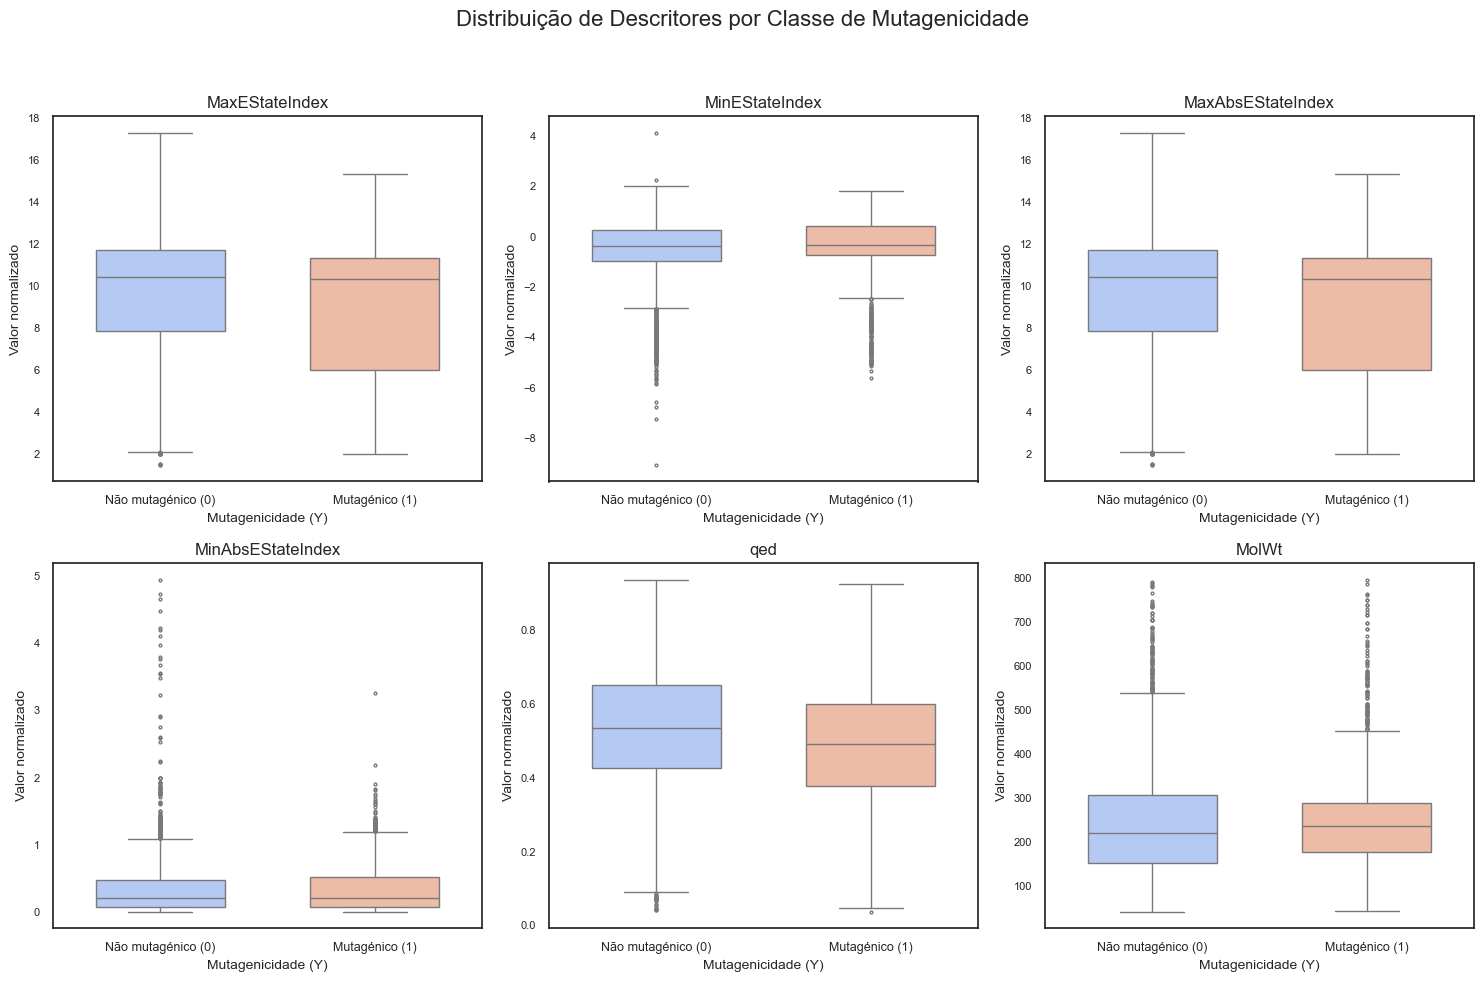

In [ ]:
# Selecionar as primeiras 6 features para visualização
selected_features = features_clean.columns[:6]

# Estilo elegante
sns.set(style="white")

# Adicionar a variável alvo 'Y' a features_clean ANTES de usar para plotagem
# This line was moved from a later cell to ensure 'Y' is present.
features_clean['Y'] = outputs_df['Y']

# Criar boxplots
plt.figure(figsize=(15, 10))
for i, feature in enumerate(selected_features):
    plt.subplot(2, 3, i + 1)
    # Agora 'Y' está presente em features_clean
    sns.boxplot(x='Y', y=feature, data=features_clean, palette='coolwarm', width=0.6, fliersize=2)
    plt.title(f'{feature}', fontsize=12)
    plt.xlabel('Mutagenicidade (Y)', fontsize=10)
    plt.ylabel('Valor normalizado', fontsize=10)
    plt.xticks([0, 1], ['Não mutagénico (0)', 'Mutagénico (1)'], fontsize=9)
    plt.yticks(fontsize=8)

plt.suptitle('Distribuição de Descritores por Classe de Mutagenicidade', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Estes boxplots comparam a distribuição de vários descritores entre classes mutagénicas e não mutagénicas.

**MaxEStateIndex:** A classe não mutagénica tende a apresentar um valor mediano ligeiramente maior em comparação com a mutagénica.

**MinEStateIndex:** Os valores medianos são semelhantes, mas a classe não mutagénica tem uma faixa interquartil mais ampla.

**MaxAbsEStateIndex:** A classe não mutagénica tem um valor mediano um pouco maior do que a mutagénica.

**MinAbsEStateIndex:** A classe não mutagénica possui uma mediana maior e apresenta mais outliers.

**qed:** As duas classes possuem valores medianos e intervalos interquartis bastante similares.

**MolWt:** A classe não mutagénica tende a ter uma mediana mais alta e uma distribuição mais ampla do que a mutagénica.

### 2.3 Correlação top 20 Features em função de Y


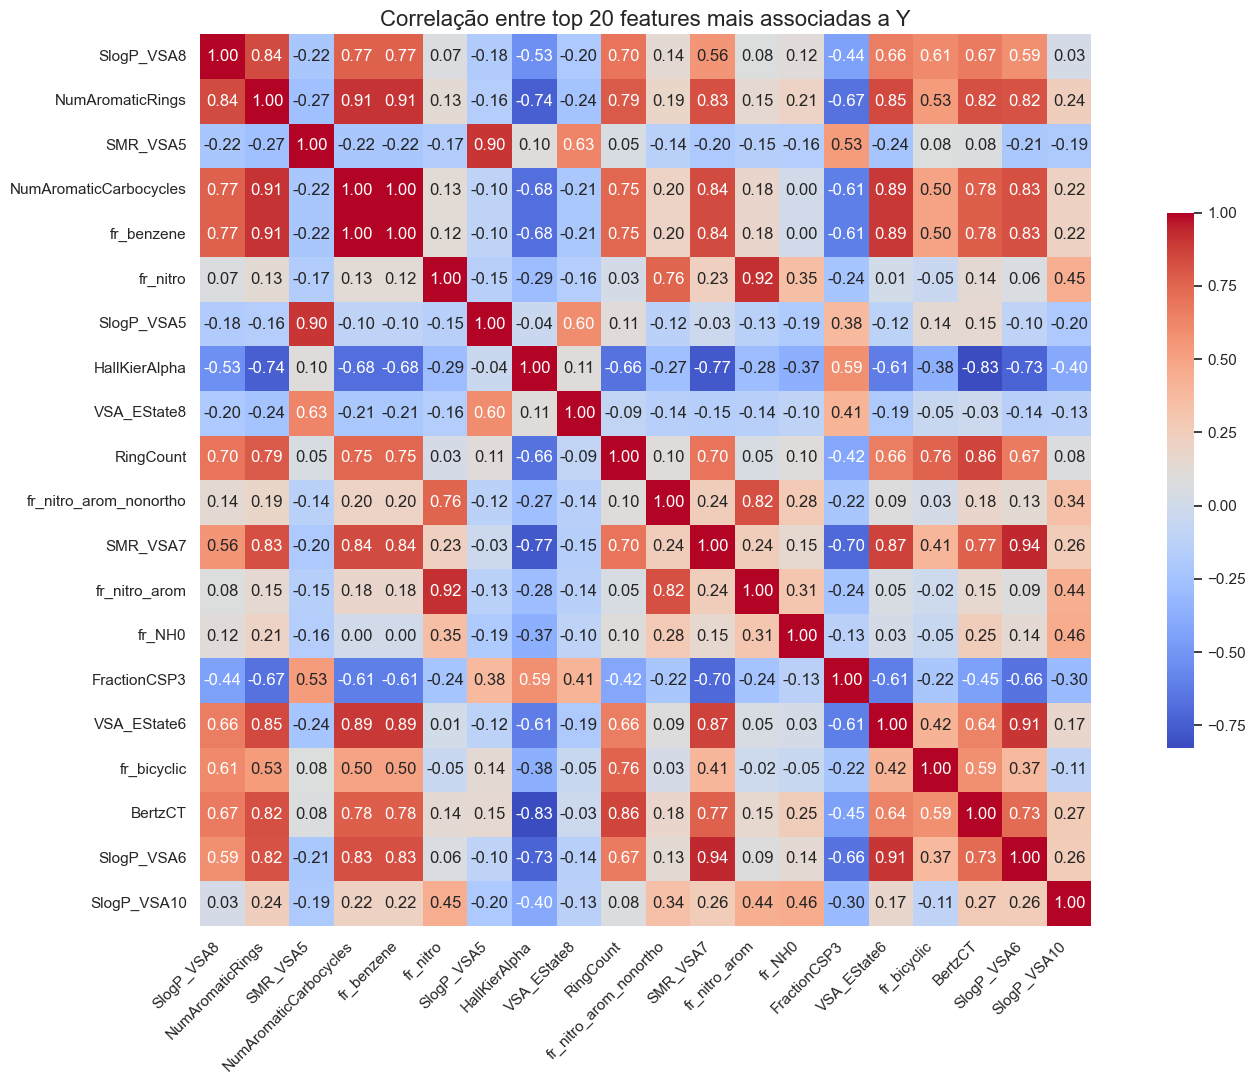

In [ ]:
# Garantir que Y está presente
features_clean['Y'] = outputs_df['Y']

# Calcular correlação
corr = features_clean.corr()

# Selecionar top 20 variáveis mais correlacionadas com Y (ignorando Y)
top_corr = corr['Y'].abs().sort_values(ascending=False)[1:21]

# Subcorrelação só com as variáveis selecionadas
top_corr_matrix = features_clean[top_corr.index].corr()

# Aumentar tamanho da figura
plt.figure(figsize=(16, 11))
sns.heatmap(top_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .6})
plt.title("Correlação entre top 20 features mais associadas a Y", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

O heatmap exibe a correlação entre as 20 principais features mais associadas à variável Y. Cada célula da matriz mostra o coeficiente de correlação entre um par de features, com valores que variam de -0.75 (indicando uma forte correlação negativa - azul) até 1.00 (correlação perfeita - vermelho). Essa disposição permite visualizar facilmente quais as features que se movem de maneira semelhante (valores positivos próximos a 1) ou de forma oposta (valores negativos próximos a -0.75).

**Grupo 1: Propriedades relacionadas à aromaticidade:**

    NumAromaticRings, NumAromaticCarbocycles, fr_benzene, fr_nitro, fr_nitro_arom

- Correlacionadas positivamente com valores acima de 0.85.
- Essas features estão todas associadas a anéis aromáticos ou grupos nitro, que são conhecidos por contribuir para a mutagenicidade em compostos.

**Grupo 2: Descritores de SlogP e SMR:**

    SlogP_VSA5, SlogP_VSA6, SlogP_VSA8, SlogP_VSA10, SMR_VSA5, SMR_VSA7

- Correlacionam fortemente entre si (valores de 0.70 a 0.94), indicando que representam propriedades de superfície e lipofilicidade de forma redundante.
- O SlogP e SMR medem características semelhantes sob perspectivas diferentes (hidrofobicidade x momento refrativo).

**Grupo 3: Propriedades estruturais e topológicas:**

    RingCount, HallKierAlpha, VSA_EState6/8:

- Ligados a número de anéis, conectividade, estado eletrónico, correlacionam moderadamente.

**Conclusões gerais:**
- Fortes agrupamentos de variáveis intercorrelacionadas
- Redundância potencial entre descritores similares
- Presença de variáveis com alto poder discriminativo (aromaticidade, grupos funcionais)

A forte co-ocorrência entre anéis aromáticos e grupos nitro sugere que motivos estruturais específicos contribuem para mutagenicidade.

## 3. Análise Estatística Multivariada Não Supervisionada

### 3.1 PCA (Análise de Componentes Principais)

Variância explicada por cada componente: [0.17022739 0.07935862]


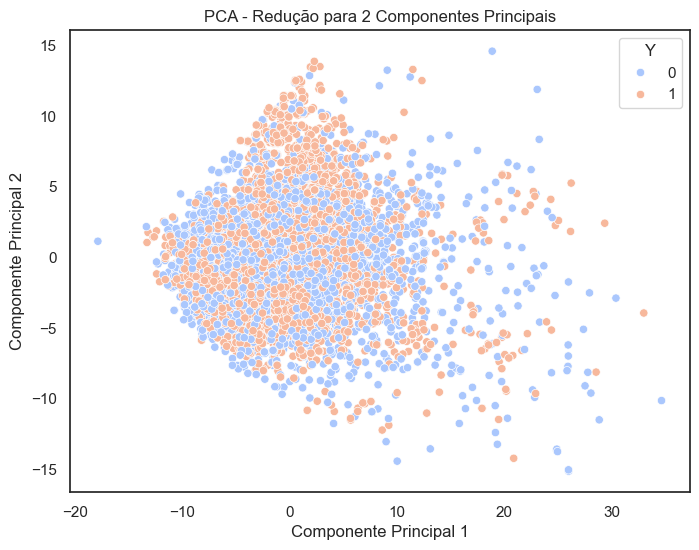

In [ ]:
# Aplicar PCA nos dados normalizados
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# Transformar em DataFrame
pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Y'] = outputs_df['Y']  # adicionar a variável alvo para visualização

# Variância explicada
print("Variância explicada por cada componente:", pca.explained_variance_ratio_)

plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='Y', data=pca_df, palette='coolwarm')
plt.title('PCA - Redução para 2 Componentes Principais')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

O gráfico mostra uma redução de dimensionalidade do dataset para 2 componentes principais (PC1 e PC2), com os pontos coloridos de acordo com a variável alvo Y:

    🔵 Y = 0 (não mutagénico)
    🟠 Y = 1 (mutagénico)

PC1 explica ≈17.0% da variância
PC2 explica ≈7.9%

- Juntas, essas duas componentes explicam apenas ≈25% da variância total. Esta baixa variância pode ser devida aos dados serem altamente multidimensionais.

As duas classes (Y = 0 e Y = 1) não estão nitidamente separadas (sem clusters evidentes) - as nuvens de pontos se sobrepõem fortemente.

A projeção mostra alguma dispersão ao longo de PC1, mas PC2 não acrescenta muito em termos de estrutura visível.

Indica que PCA não é suficiente para discriminar entre mutagénicos e não-mutagénicos. Isto acontece quando a separação entre classes não é linear ou as variáveis mais relevantes para a classificação não são aquelas com maior variância.

### 3.2 Clustering

#### 3.2.1 Método do Catovelo para escolha de k

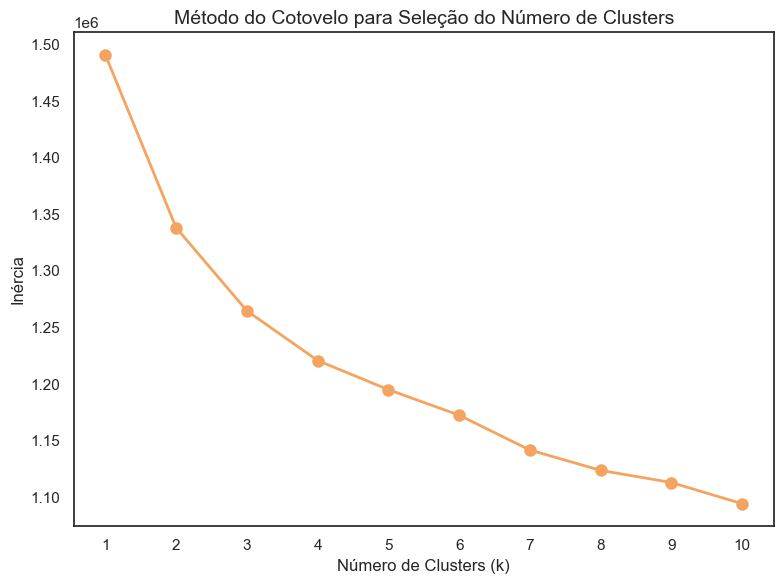

In [ ]:
# Calcular inércia para k de 1 a 10
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Estilo elegante sem grid
sns.set(style='white')  # estilo limpo

plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, marker='o', color='sandybrown', linewidth=2, markersize=8)
plt.xticks(K_range)
plt.title('Método do Cotovelo para Seleção do Número de Clusters', fontsize=14)
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Inércia', fontsize=12)
plt.tight_layout()
plt.show()

Eixo X: Número de clusters kk, variando de 1 a 10.
Eixo Y: Inércia (ou soma das distâncias quadradas intra-cluster), que mede o quão compactos estão os clusters.
Linha laranja: Mostra a diminuição da inércia à medida que aumentamos k.

O ponto onde o ganho de compactação (redução de inércia) começa a diminuir significativamente - K=2.

#### 3.2.2 K-means: clusters no espeço PCA

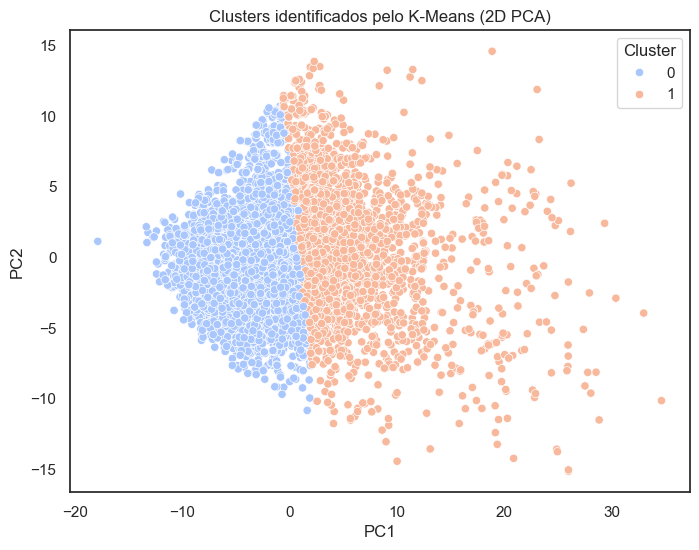

In [ ]:
# Vamos assumir 2 clusters como exemplo
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Adicionar clusters ao DataFrame do PCA
pca_df['Cluster'] = clusters

plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='coolwarm')
plt.title('Clusters identificados pelo K-Means (2D PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

O gráfico mostra os clusters identificados pelo algoritmo K-Means após redução de dimensionalidade por PCA.

    🔵 Cluster 0
    🟠 Cluster 1

**Separação clara entre clusters:**
- A divisão entre os dois grupos é visualmente perceptível ao longo do eixo PC1.
- Isto sugere que os dados possuem estrutura latente que K-Means conseguiu capturar razoavelmente bem.

**Simetria dos dados:**
- O cluster azul e o laranja parecem quase espelhados em relação a PC1 = 0. Isso reforça que o PCA ajudou a revelar a separação natural nos dados.

**Sobreposição parcial:**
- Há uma zona de transição em torno de PC1 ≈ 0 onde os clusters se sobrepõem.
- Isso pode indicar que as fronteiras entre clusters não são perfeitamente lineares — uma limitação do K-Means, que assume fronteiras esféricas.

### 3.3 Interpretação dos componentes principais

#### 3.3.1 Tabela com os 6 descritores com maior peso (PC1 e PC2)

In [ ]:
# Loadings dos componentes principais
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features_clean.columns[:205])

# Maiores contribuidores para PC1 e PC2
top_pc1 = loadings['PC1'].abs().sort_values(ascending=False).head(6)
top_pc2 = loadings['PC2'].abs().sort_values(ascending=False).head(6)

In [ ]:
# Criar DataFrame combinado para exibir os top 6 descritores de PC1 e PC2
top_pc_df = pd.DataFrame({
    'Top PC1 Features': top_pc1.index,
    'PC1 Loadings': top_pc1.values,
    'Top PC2 Features': top_pc2.index,
    'PC2 Loadings': top_pc2.values
})

top_pc_df.style.set_caption("Top 6 Contribuidores para PC1 e PC2") \
               .format({'PC1 Loadings': '{:.4f}', 'PC2 Loadings': '{:.4f}'}) \
               .hide(axis='index') \
               .set_table_styles([
                   {'selector': 'caption',
                    'props': [('color', '#333'),
                              ('font-size', '16px'),
                              ('text-align', 'left'),
                              ('font-weight', 'bold'),
                              ('margin-bottom', '10px')]},
                   {'selector': 'th',
                    'props': [('background-color', 'lightsteelblue'),
                              ('padding', '8px')]},
                   {'selector': 'td',
                    'props': [('padding', '8px')]}
               ])



Top PC1 Features,PC1 Loadings,Top PC2 Features,PC2 Loadings
NumValenceElectrons,0.1658,VSA_EState6,0.1896
Chi0,0.1658,MolLogP,0.1865
HeavyAtomCount,0.1650,fr_benzene,0.1714
Chi1,0.1636,NumAromaticCarbocycles,0.1714
LabuteASA,0.1631,SlogP_VSA6,0.1633
Chi0n,0.1606,NumAromaticRings,0.1626


Os resultados apresentados mostram os seis descritores que mais contribuíram para os dois primeiros componentes principais (PC1 e PC2), juntamente com os seus respectivos coeficientes de carga (loadings), que refletem o peso de cada variável na construção de cada componente.

**PC1:**
O PC1 parece estar fortemente associado a propriedades estruturais e topológicas gerais da molécula, como número de eletrões de valência, número de átomos pesados e índices de conectividade (Chi0, Chi1, Chi0n). Essas variáveis são indicativas da tamanho e forma da molécula, influenciando sua complexidade estrutural.

**PC2:**
O PC2 é dominado por descritores relacionados à aromaticidade (e.g., fr_benzene, NumAromaticRings), logP (MolLogP, SlogP_VSA6), e propriedades eletrónicas de superfície (VSA_EState6). Estes descritores capturam aspectos mais eletrónicos e lipofílicos da molécula, além de sua propensão à planaridade e estabilidade conferidas por anéis aromáticos.

#### 3.3.2 Barplots dos descritores-chave por cluster

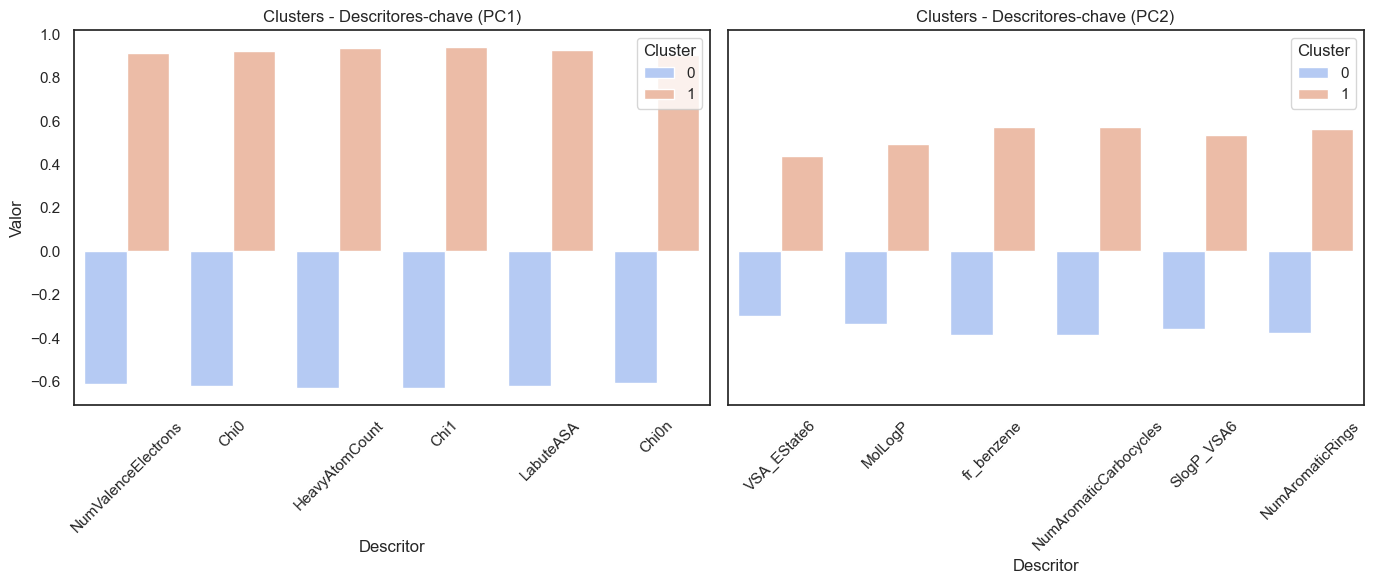

In [ ]:
# Supondo que 'features_scaled' são os dados normalizados e 'clusters' são os rótulos do KMeans
features_clustered = pd.DataFrame(features_scaled, columns=features_clean.drop(columns=['Y']).columns)
features_clustered['Cluster'] = clusters

# Calcular a média de cada descritor por cluster
cluster_profile = features_clustered.groupby('Cluster').mean().T  # transposto para que descritores fiquem no índice

# Long format para PC1
cluster_profile_pc1 = cluster_profile.loc[top_pc1.index].reset_index().melt(id_vars='index', var_name='Cluster', value_name='Valor')
cluster_profile_pc1.rename(columns={'index': 'Descritor'}, inplace=True)

# Long format para PC2
cluster_profile_pc2 = cluster_profile.loc[top_pc2.index].reset_index().melt(id_vars='index', var_name='Cluster', value_name='Valor')
cluster_profile_pc2.rename(columns={'index': 'Descritor'}, inplace=True)

# Criar subplots lado a lado
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# PC1
sns.barplot(data=cluster_profile_pc1, x='Descritor', y='Valor', hue='Cluster', palette='coolwarm', ax=axes[0])
axes[0].set_title("Clusters - Descritores-chave (PC1)")
plt.setp(axes[0].get_xticklabels(), rotation=45)

# PC2
sns.barplot(data=cluster_profile_pc2, x='Descritor', y='Valor', hue='Cluster', palette='coolwarm', ax=axes[1])
axes[1].set_title("Clusters - Descritores-chave (PC2)")
plt.setp(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

Os gráficos apresentam os descritores moleculares mais relevantes para separação dos clusters obtidos pelo K-Means, conforme projeção nos dois primeiros componentes principais (PC1 e PC2) da análise de componentes principais (PCA).

**Painel da Esquerda – PC1**

Representa os descritores com maior peso na primeira componente principal, que explicou boa parte da variância entre os clusters:

    Cluster 0 (azul): valores mais baixos consistentemente.
    Cluster 1 (laranja): valores mais altos.

**Principais descritores destacados:**

    - NumValenceElectrons, HeavyAtomCount: relacionados ao tamanho e complexidade da molécula.
    - Chi0, Chi1, Chi0n: índices topológicos associados à conectividade e ramificações.
    - LabuteASA: estimativa da área de superfície acessível ao solvente, relacionada à hidrofobicidade.

O cluster 1 agrupa compostos maiores e mais conectados, enquanto o cluster 0 concentra compostos menores e mais simples.


**Painel da Direita – PC2**

Representa os descritores que mais contribuíram para a segunda componente principal, separando os clusters de forma ortogonal à PC1.

**Descritores relevantes:**

    - VSA_Estate6, SlogP_VSA6: hidrofobicidade e superfície polar.
    - MolLogP: medida da lipofilicidade (coeficiente de partição).
    - f_benzene, NumAromaticRings, NumAromaticCarbocycles: presença de anéis aromáticos.

O cluster 1 tende a ter maior aromaticidade e lipofilicidade, enquanto o cluster 0 possui menos estruturas aromáticas e é potencialmente mais polar.


A separação dos clusters parece ser influenciada por:
- Tamanho e complexidade molecular (PC1).
- Aromaticidade e propriedades físico-químicas como logP e área de superfície (PC2).

### 3.4 Visualização das variáveis mais informativas

#### 3.4.1 Mutual information entre descritores e Y

In [ ]:
# Calcular os scores de mutual information entre as features e a variável alvo
mi_scores = mutual_info_classif(features_clean.drop(columns=['Y']), features_clean['Y'], random_state=42)

# Criar DataFrame com os nomes das variáveis e seus scores
mi_df = pd.DataFrame({
    'Variable': features_clean.drop(columns=['Y']).columns,
    'MI': mi_scores
})

# Ordenar do mais informativo para o menos
mi_df = mi_df.sort_values(by='MI', ascending=False)

#### 3.4.2 Histogramas das 6 variáveis mais informativas

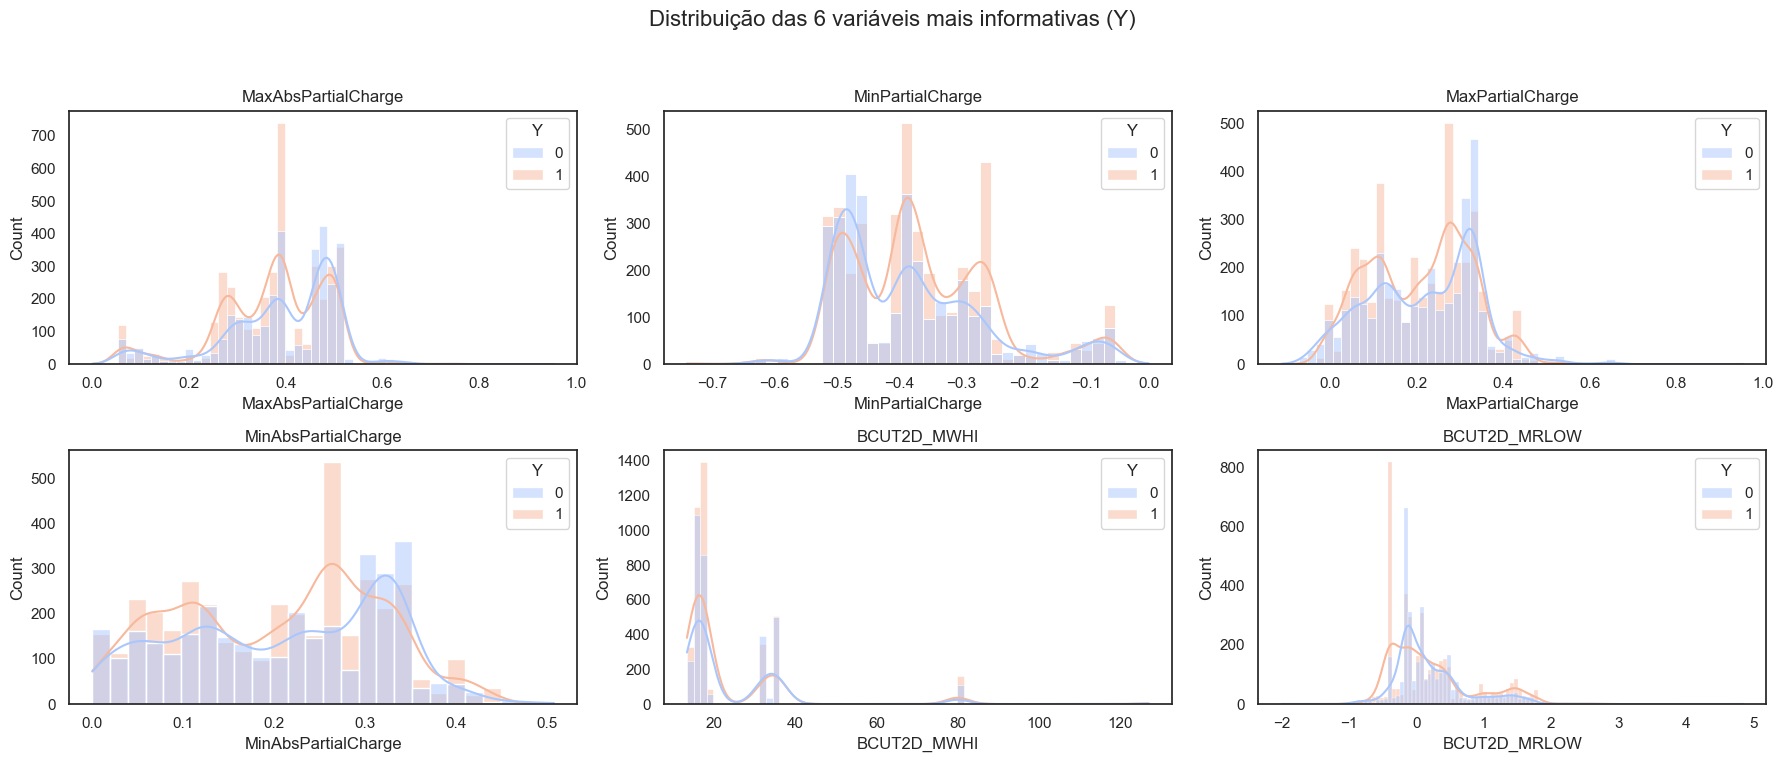

In [ ]:
# Selecionar só as 6 variáveis com maior mutual information
top_vars = mi_df.head(6)

# Criar figura única com 2 linhas e 3 colunas
fig, axs = plt.subplots(2, 3, figsize=(18, 8))
axs = axs.flatten()  # transforma em vetor para indexar facilmente

for i, var in enumerate(top_vars['Variable']):
    sns.histplot(data=features_clean, x=var, hue='Y', kde=True, palette='coolwarm', ax=axs[i])
    axs[i].set_title(f'{var}')

# Desativar eixos vazios (caso hajam menos de 6 variáveis, por segurança)
for j in range(len(top_vars), len(axs)):
    axs[j].axis('off')

plt.suptitle("Distribuição das 6 variáveis mais informativas (Y)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Os gráficos representam a distribuição das 6 variáveis mais relevantes para distinguir entre compostos mutagénicos (Y=1) e não-mutagénicos (Y=0). Cada histograma compara a densidade das amostras em ambas as classes, permitindo observar padrões discriminativos.

**1. MaxAbsPartialCharge**

    - Reflete o maior valor absoluto de carga parcial num átomo da molécula
    - Compostos mutagénicos (laranja) tendem a ter uma distribuição ligeiramente mais concentrada (0.35–0.45)
    - Não-mutagénicos (azul) apresentam maior dispersão e valores ligeiramente mais altos.

**2. MinPartialCharge**

    - Reflete a menor carga parcial (mais negativa)
    - Mutagénicos tendem a concentrar-se em torno de -0.4, enquanto não-mutagénicos possuem cauda mais alongada à esquerda, com valores mais negativos
    - Pode indicar presença de átomos mais eletronegativos nos compostos não-mutagénicos

**3. MaxPartialCharge**

    - Valor mais positivo de carga parcial
    - Ambas as classes são relativamente similares, mas os não-mutagénicos mostram leve deslocamento à direita, indicando cargas parciais positivas mais altas em alguns casos

**4. MinAbsPartialCharge**

    - Módulo da menor carga parcial (sem sinal)
    - Os não-mutagénicos mostram uma tendência de valores mais elevados, sugerindo maior polaridade extrema em regiões da molécula

**5. BCUT2D_MWHI**

    - Descritor BCUT ponderado pelo peso atômico (alto valor)
    - Mutagénicos tendem a ter valores mais altos, possivelmente indicando maior diversidade estrutural ou presença de átomos pesados

**6. BCUT2D_MRLOW**

    - BCUT ponderado pela molar refratividade (baixo valor)
    - Mutagénicos mostram maior variação e valores mais positivos, sugerindo diferenças na flexibilidade ou compactação eletrónica

### 3.6 UMAP (Uniform Manifold Approximation and Projection)

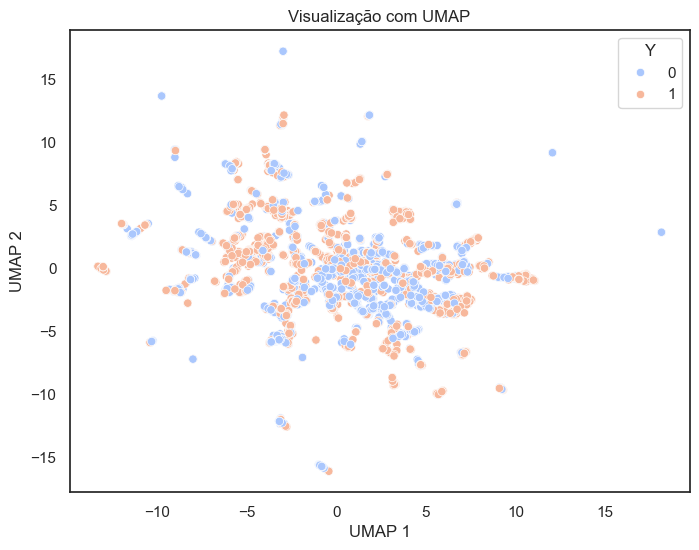

In [ ]:
reducer = umap.UMAP(random_state=42)
X_umap = reducer.fit_transform(features_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_umap[:,0], y=X_umap[:,1], hue=outputs_df["Y"], palette='coolwarm')
plt.title("Visualização com UMAP")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()


O gráfico tem como objetivo representar os dados em 2D, preservando tanto a estrutura local quanto global.

    🔵 Y = 0 (não mutagénico)
    🟠 Y = 1 (mutagénico)

**Distribuição naturalista:**
- Os pontos não estão forçados a uma forma linear ou cartesiana - característico do UMAP.

**Agrupamentos visíveis (suaves):**
- Apesar de não haver uma separação explícita entre as classes, é possível observar tendências de agrupamento suave por cor. Algumas regiões parecem ter uma concentração maior de uma das classes.

**Sobreposição significativa:**
- A ausência de separação clara nos dados com base apenas nos dois eixos UMAP ou que os descritores moleculares utilizados não são suficientes para discriminar bem entre as classes.

**Escala assimétrica e dispersão não uniforme:**
- Os dados estão espalhados principalmente entre valores positivos no eixo UMAP1 e valores entre 0–25 no UMAP2

A visualização UMAP confirma que os dados possuem estrutura interna, mas com alta sobreposição entre classes.

Não há separação linear ou agrupamentos evidentes — o que é esperado se a distinção entre as classes depende de relações complexas entre múltiplos descritores.

### 3.7 t-SNE (t-distributed Stochastic Neighbor Embedding)

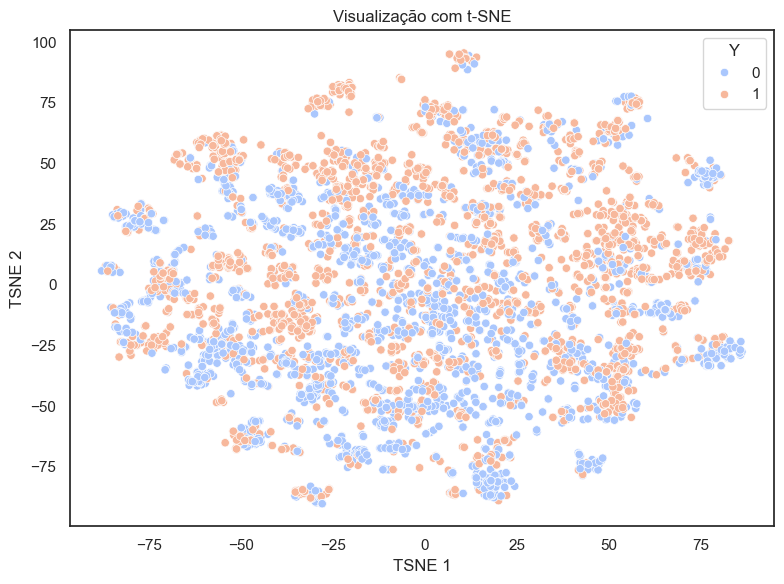

In [ ]:
# Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(features_scaled)

# Visualizar resultados
tsne_df = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
tsne_df["Y"] = outputs_df["Y"]

plt.figure(figsize=(8,6))
sns.scatterplot(data=tsne_df, x="TSNE1", y="TSNE2", hue="Y", palette='coolwarm')
plt.title("Visualização com t-SNE")
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.tight_layout()
plt.show()

O gráfico tem o objetivo de preservar relações locais entre os pontos de alta dimensão em um espaço 2D — ou seja, colocar próximos no plano os pontos que são similares nos dados originais.

    🔵 Y = 0 (não mutagénico)
    🟠 Y = 1 (mutagénico)

**Preservação local aparente:**
- Algumas microestruturas com pontos da mesma cor próximos indicam que t-SNE conseguiu preservar vizinhanças locais dos dados originais.

**Distribuição rica e não linear:**
- O t-SNE revela complexidades não captadas pelo PCA, com padrões curvos e espalhados - relações são não lineares.

**Alta sobreposição entre as classes:**
- As classes estão muito intercaladas e não formam clusters bem definidos

**Interpretação não trivial:**
- t-SNE não preserva distâncias globais nem variações marginais como o PCA. Não é possível afirmar que "grupos" no gráfico são verdadeiramente distintos no espaço original.

O t-SNE reforça a dificuldade de separação clara entre as classes 0 e 1.

Apesar de revelar algumas zonas com maior concentração de uma classe, não há um padrão suficientemente definido para justificar clustering puro.

#### 3.8 Avaliação do Clustering - Silhouette_score

Silhouette Score para K-Means com k=2: 0.136


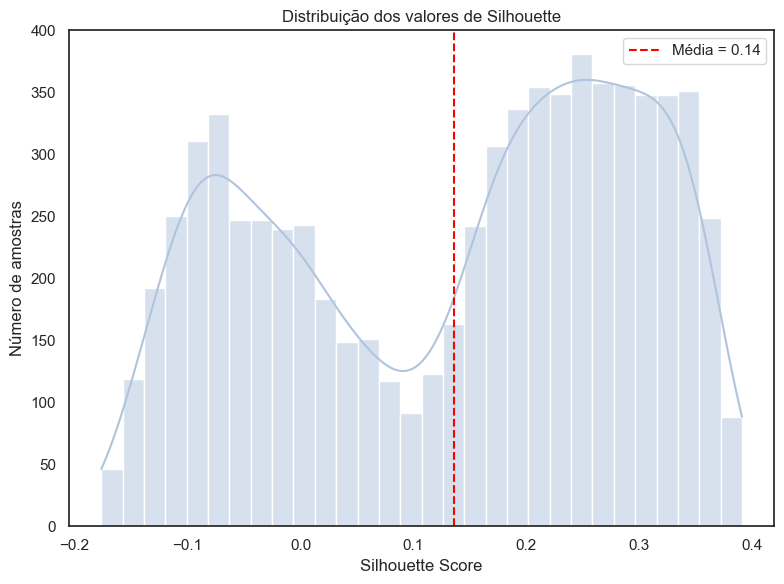

In [ ]:
# Avaliação do clustering com silhouette score
sil_score = silhouette_score(features_scaled, clusters)
print(f"Silhouette Score para K-Means com k=2: {sil_score:.3f}")

sil_values = silhouette_samples(features_scaled, clusters)

plt.figure(figsize=(8,6))
sns.histplot(sil_values, bins=30, kde=True, color='lightsteelblue')
plt.axvline(sil_score, color='red', linestyle='--', label=f'Média = {sil_score:.2f}')
plt.title("Distribuição dos valores de Silhouette")
plt.xlabel("Silhouette Score")
plt.ylabel("Número de amostras")
plt.legend()
plt.tight_layout()
plt.show()


O valor de silhouette ajuda a avaliar a coesão e separação dos clusters. Valores mais próximos de 1 indicam melhor separação.

**Valor Médio = 0.136**
- Indica baixa coesão e separação entre os clusters. Um valor abaixo de 0.25 sugere estrutura fraca ou inexistente de clusters nos dados.

**Distribuição bimodal**
- A distribuição apresenta dois picos: um em torno de -0.1 e outro em +0.25. Uma parte dos pontos está mal atribuída (valores negativos). Outra parte parece estar razoavelmente agrupada.

**Valores negativos (~-0.2 até 0):**
- Um número significativo de pontos tem scores negativos → provável sobreposição entre clusters ou fronteiras mal definidas.

O KMeans está a forçar uma separação em 2 grupos sem uma estrutura natural clara.

Isso é coerente com:
- O gráfico PCA → onde as classes 0 e 1 se sobrepõem.
- As projeções UMAP e t-SNE → também mostraram forte mistura entre classes.
- A análise do cotovelo → indicava possível melhoria até k=2

## 4. RDKit - Representação Visual dos Compostos-Chave

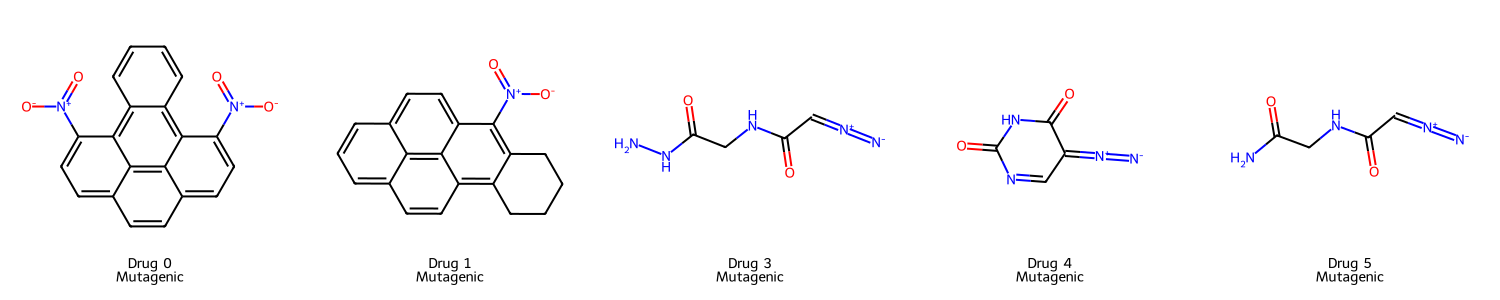

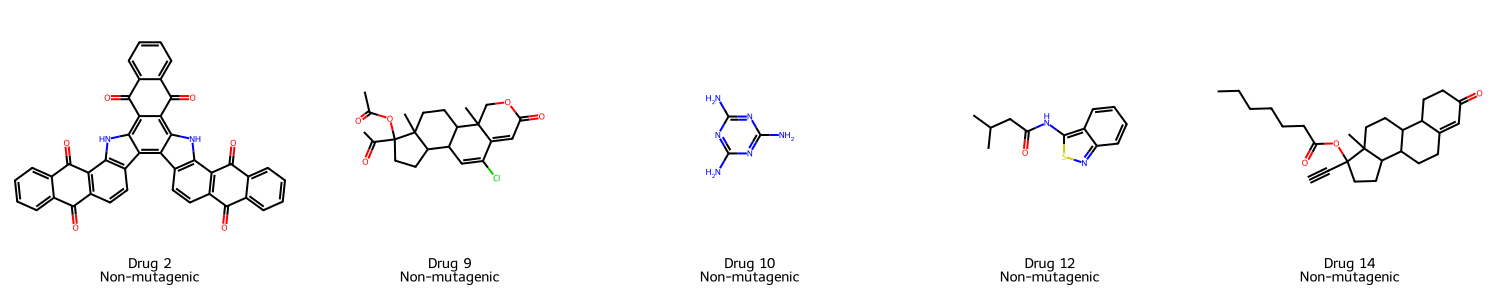

In [ ]:
# Obter os 5 primeiros compostos mutagénicos e não mutagénicos
mut_df = outputs_df[outputs_df["Y"] == 1].head()
nonmut_df = outputs_df[outputs_df["Y"] == 0].head()

# Criar moléculas
mol_mut = [Chem.MolFromSmiles(s) for s in mut_df["smiles"]]
mol_nonmut = [Chem.MolFromSmiles(s) for s in nonmut_df["smiles"]]

# Criar legendas com ID (ou qualquer coluna relevante)
legends_mut = [f"{row['ids']}\nMutagenic" for _, row in mut_df.iterrows()]
legends_nonmut = [f"{row['ids']}\nNon-mutagenic" for _, row in nonmut_df.iterrows()]

# Gerar imagens
img_mut = Draw.MolsToGridImage(mol_mut, molsPerRow=5, subImgSize=(300, 300), legends=legends_mut)
img_nonmut = Draw.MolsToGridImage(mol_nonmut, molsPerRow=5, subImgSize=(300, 300), legends=legends_nonmut)

# Mostrar
display(img_mut)
display(img_nonmut)


Nesta etapa, foi utilizada a biblioteca RDKit para gerar uma representação visual dos compostos químicos selecionados do conjunto de dados, com o objetivo de comparar exemplos de compostos mutagénicos e não mutagénicos.

- Estes compostos podem ser considerados representativos ("centroide-like") dos respectivos clusters em análises anteriores, como K-Means.

Foram selecionados os 5 primeiros compostos mutagênicos (Y=1) e 5 não mutagênicos (Y=0) a partir do DataFrame.

As estruturas moleculares foram convertidas a partir de strings SMILES usando Chem.MolFromSmiles.

**As imagens foram geradas com Draw.MolsToGridImage, apresentando:**
    
    - A estrutura química
    - O ID da molécula
    - A classificação (Mutagenic/Non-mutagenic)

**Compostos Mutagénicos:**
- Muitos deles apresentam grupos nitro (-NO₂) ou sistemas aromáticos planos, frequentemente associados a potencial mutagênico (ex: intercalantes de DNA).

- Apresentam maior conjugação eletrônica e grupos funcionais potencialmente reativos.

**Compostos Não Mutagénicos:**
- Estruturas mais complexas ou volumosas, menos planas.
- Presença de grupos apolares ou heteroátomos isolados, menos associados à reatividade com DNA.

# 5. Analise Supervisionada

#### 5.1 Lazy Predict com Stratified K-Fold Cross Validation

Para avaliar de forma robusta o desempenho de diversos modelos de classificação aplicados ao problema de previsão da mutagenicidade de compostos químicos, utilizamos a biblioteca LazyPredict em conjunto com Stratified K-Fold Cross Validation com cinco folds.

O objetivo é comparar automaticamente múltiplos classificadores supervisionados de forma a escolher os cinco melhores e aplica-los manualmente. Para isso, empregamos o LazyClassifier, que testa dezenas de algoritmos de machine learning com os seus parâmetros padrão, avaliando métricas relevantes como Acuraccy, Balanced Accuracy, ROC AUC (), F1-score e Time Taken.

O uso de Stratified K-Fold, garante que a proporção entre classes (mutagénico vs. não mutagénico) é mantida em cada fold. Isto assegura uma avaliação mais equilibrada, reduz a variabilidade nos resultados e evita conclusões enviesadas devido à distribuição desigual das classes. No contexto deste trabalho, permite comparar de forma fiável o desempenho médio de vários classificadores sobre o conjunto de dados.


**O script implementado realiza os seguintes passos:**

**Divisão inicial dos dados:**
 - O conjunto total de dados foi dividido em 80% para treino e 20% para teste, mantendo a proporção original das classes (mutagénicos vs. não mutagénicos) através de estratificação. Esta divisão assegura a existência de um conjunto de teste independente, reservado exclusivamente para avaliação final dos modelos.

**Validação cruzada estratificada sobre o treino (Stratified K-Fold):**
 - O subconjunto de treino (80%) foi submetido a uma validação cruzada estratificada com 5 folds, garantindo que cada partição mantinha a proporção entre classes. Para cada fold, foram definidos conjuntos de treino (80%) e validação (20%).

**Aplicação do LazyClassifier:**
- Em cada fold, foi utilizado o LazyClassifier

**Agregação e comparação dos modelos:**
- Os resultados de todos os folds foram combinados e agregados por modelo, permitindo calcular as médias das métricas de desempenho. Isso permitiu comparar os classificadores de forma justa e robusta, sem sobreajuste, utilizando apenas os dados de treino.

Este procedimento garante que a escolha dos modelos mais promissores é feita com base numa avaliação rigorosa, sem expor os dados de teste antes da fase final. O conjunto de teste separado (20%) será posteriormente utilizado para avaliar os modelos selecionados de forma definitiva.

In [ ]:
# Separar 80% treino e 20% teste
X_train_full, X_test, y_train_full, y_test = train_test_split(
    features_scaled, outputs_df["Y"].values, test_size=0.2, stratify=outputs_df["Y"], random_state=42
)

# Stratified k-Fold nos 80% de treino
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Armazenar resultados
fold_results = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_train_full, y_train_full)):
    print(f"\nFold {fold+1}")

    X_train, X_val = X_train_full[train_idx], X_train_full[test_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[test_idx]

    clf = LazyClassifier(verbose=0, ignore_warnings=True)
    models, predictions = clf.fit(X_train, X_val, y_train, y_val)

    models["Fold"] = fold + 1
    fold_results.append(models)

# Combinar resultados de todos os folds
results_df = pd.concat(fold_results).reset_index()

# Agrupar corretamente e tirar média
mean_results = results_df.groupby("Model")[["Accuracy", "Balanced Accuracy", "ROC AUC", "F1 Score", "Time Taken"]].mean()

# Ordenar por Accuracy
mean_results = mean_results.sort_values(by="Accuracy", ascending=False)

# Ver top 10
display(mean_results.head(10))



Fold 1


  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2543, number of negative: 2111
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 22440
[LightGBM] [Info] Number of data points in the train set: 4654, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546412 -> initscore=0.186183
[LightGBM] [Info] Start training from score 0.186183

Fold 2


  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2543, number of negative: 2111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22456
[LightGBM] [Info] Number of data points in the train set: 4654, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546412 -> initscore=0.186183
[LightGBM] [Info] Start training from score 0.186183

Fold 3


  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2543, number of negative: 2111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007628 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22461
[LightGBM] [Info] Number of data points in the train set: 4654, number of used features: 187
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546412 -> initscore=0.186183
[LightGBM] [Info] Start training from score 0.186183

Fold 4


  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2544, number of negative: 2111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.562465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22458
[LightGBM] [Info] Number of data points in the train set: 4655, number of used features: 188
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546509 -> initscore=0.186576
[LightGBM] [Info] Start training from score 0.186576

Fold 5


  0%|          | 0/31 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 2543, number of negative: 2112
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007640 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22454
[LightGBM] [Info] Number of data points in the train set: 4655, number of used features: 189
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546294 -> initscore=0.185709
[LightGBM] [Info] Start training from score 0.185709


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
ExtraTreesClassifier,0.83,0.83,0.83,0.83,1.83
RandomForestClassifier,0.82,0.82,0.82,0.82,4.48
LGBMClassifier,0.82,0.82,0.82,0.82,2.21
XGBClassifier,0.82,0.82,0.82,0.82,2.86
BaggingClassifier,0.81,0.81,0.81,0.81,6.57
NuSVC,0.81,0.81,0.81,0.81,7.04
SVC,0.81,0.81,0.81,0.81,6.55
KNeighborsClassifier,0.78,0.78,0.78,0.78,0.12
CalibratedClassifierCV,0.77,0.77,0.77,0.77,34.16


##### **Resultados**

Os resultados obtidos mostram que os classificadores **ExtraTreesClassifier**, **RandomForestClassifier**, **LGBMClassifier** e **XGBClassifier** foram consistentemente os mais eficazes, apresentando valores médios de Acuraccy, Balanced Accuracy, ROC AUC (), F1-score e Time Taken iguais ou superiores a 0.82, com tempos de execução relativamente baixos.

Estes resultados indicam que esses modelos são fortes candidatos à implementação final. A fase seguinte do trabalho consistirá em treinar manualmente os modelos mais promissores usando a totalidade dos dados de treino (80%) e avaliar o seu desempenho final no conjunto de teste independente (20%), que não foi utilizado em nenhum momento da validação.

##### **Ajuste e Avaliação Final dos Modelos Selecionados**

Para cada um destes modelos, foi aplicado o mesmo processo de fine-tuning e avaliação final, descrito a seguir.

**Ajuste de hiperparâmetros com GridSearchCV:**
- Para cada modelo, foi definida uma grelha de hiperparâmetros relevantes, baseada na documentação oficial. O GridSearchCV foi utilizado com validação cruzada estratificada (5 folds) e a métrica de pbalenced accuracy como critério de otimização. Esta métrica foi escolhida por ser mais adequada em problemas com possível desequilíbrio de classes, como é o caso da predição de mutagenicidade.

**Treino do modelo otimizado:**
- O melhor conjunto de hiperparâmetros encontrado foi utilizado para treinar cada modelo sobre a totalidade do conjunto de treino (80% dos dados), que havia sido previamente separado antes da validação cruzada.

**Avaliação final no conjunto de teste:**
- Com os modelos finais treinados, foram feitas previsões sobre o conjunto de teste (20% dos dados, não utilizado anteriormente). Para cada modelo, foram geradas a matriz de confusão e o relatório de classificação, contendo as principais métricas de desempenho: precision, recall, F1-score, e accuracy.

Este processo garante uma comparação justa entre os modelos, permitindo avaliar com confiança qual deles apresenta o melhor desempenho realista para o problema de predição da mutagenicidade com base nas representações moleculares disponíveis.

#### 5.2 ExtraTreesClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.tree.ExtraTreeClassifier.html

O ExtraTreesClassifier (Extremely Randomized Trees) é um ensemble de árvores de decisão que se baseia na técnica de bagging. Este modelo escolhe os pontos de divisão de forma completamente aleatória, o que aumenta a diversidade entre as árvores e reduz a variância. É conhecido por ser muito rápido, robusto a overfiting, e eficiente em datasets com muitas variáveis.

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

grid = GridSearchCV(
    ExtraTreesClassifier(random_state=42),
    param_grid,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_full, y_train_full)
print("Melhores Parâmetros:", grid.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Melhores Parâmetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}


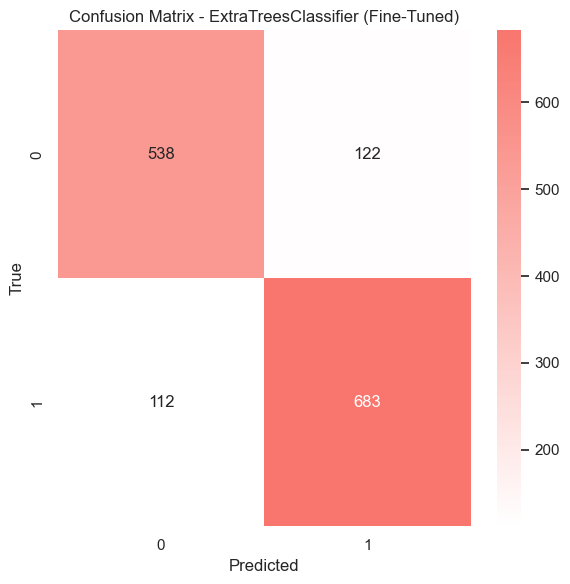


Relatório de Classificação:
              precision    recall  f1-score   support

           0     0.8277    0.8152    0.8214       660
           1     0.8484    0.8591    0.8538       795

    accuracy                         0.8392      1455
   macro avg     0.8381    0.8371    0.8376      1455
weighted avg     0.8390    0.8392    0.8391      1455



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from matplotlib.colors import LinearSegmentedColormap

# Definir o modelo com os melhores parâmetros
best_et = ExtraTreesClassifier(
    max_depth=None,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=500,
    random_state=42
)

# Treinar com todos os dados de treino
best_et.fit(X_train_full, y_train_full)

# Fazer previsões no conjunto de teste
y_pred = best_et.predict(X_test)

# Previsões
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=2, output_dict=True)
labels = best_et.classes_

custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap", ["#FFFFFF", "#F8766D"]
)

# Plot
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d',cmap=custom_cmap, xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - ExtraTreesClassifier (Fine-Tuned)")
plt.xlabel("Predicted")
plt.ylabel("True")


plt.tight_layout()
plt.show()

# Gerar e mostrar o relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, digits=4))


#### 5.3 RandomForestClassifier

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

O RandomForestClassifier também é um ensemble de árvores de decisão baseado em bagging, mas escolhe os pontos de divisão com base em medidas como a entropia ou o índice de Gini. É um dos modelos mais utilizados em tarefas de classificação pela sua alta estabilidade e desempenho consistente, mesmo sem grandes afinações de parâmetros.

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_full, y_train_full)
print("Melhores Parâmetros", grid.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Melhores Parâmetros {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}


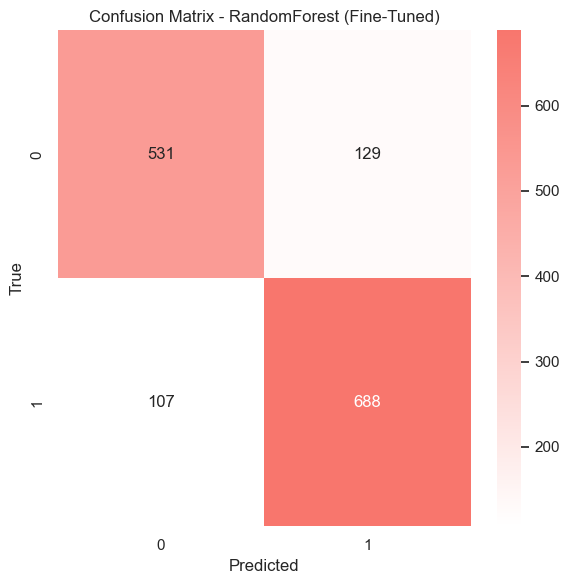


Relatório de Classificação:
              precision    recall  f1-score   support

           0     0.8323    0.8045    0.8182       660
           1     0.8421    0.8654    0.8536       795

    accuracy                         0.8378      1455
   macro avg     0.8372    0.8350    0.8359      1455
weighted avg     0.8377    0.8378    0.8375      1455



In [ ]:
# Definir o modelo com os melhores parâmetros
best_rf = RandomForestClassifier(
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=5,
    n_estimators=500,
    random_state=42
)

# Treinar com todos os dados de treino
best_rf.fit(X_train_full, y_train_full)

# Fazer previsões no conjunto de teste
y_pred = best_rf.predict(X_test)

# Previsões
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=2, output_dict=True)
labels = best_rf.classes_

# Plot
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap, xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - RandomForest (Fine-Tuned)")
plt.xlabel("Predicted")
plt.ylabel("True")


plt.tight_layout()
plt.show()

# Gerar e mostrar o relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, digits=4))


#### 5.4 LGBMClassifier

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

O LGBMClassifier faz parte da família de algoritmos gradient boosting, implementado na biblioteca LightGBM. É especialmente concebido para ser altamente eficiente e escalável, utilizando histogramas para acelerar o treino. Destaca-se pelo seu excelente desempenho em datasets tabulares com grande número de instâncias e atributos.

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 10, -1],
    'num_leaves': [15, 31, 63],
    'min_child_samples': [10, 20, 30],
}

grid = GridSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_full, y_train_full)

print("Melhores Parâmetros:", grid.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Info] Number of positive: 3179, number of negative: 2639
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22666
[LightGBM] [Info] Number of data points in the train set: 5818, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546408 -> initscore=0.186167
[LightGBM] [Info] Start training from score 0.186167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[LightGBM] [Info] Number of positive: 3179, number of negative: 2639
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22666
[LightGBM] [Info] Number of data points in the train set: 5818, number of used features: 190
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546408 -> initscore=0.186167
[LightGBM] [Info] Start training from score 0.186167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


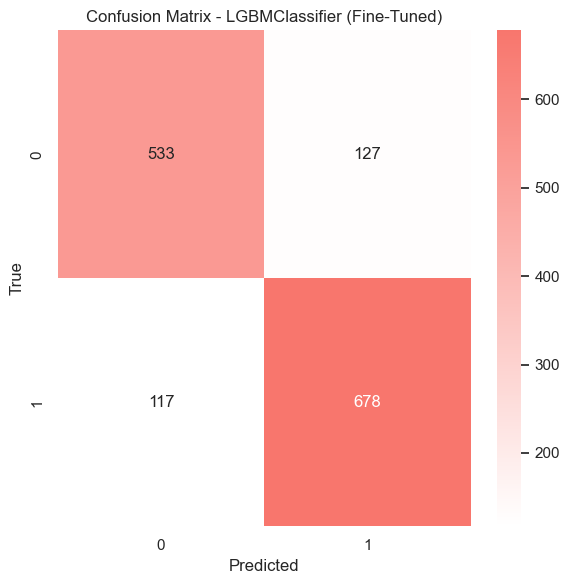


Relatório de Classificação:
              precision    recall  f1-score   support

           0     0.8200    0.8076    0.8137       660
           1     0.8422    0.8528    0.8475       795

    accuracy                         0.8323      1455
   macro avg     0.8311    0.8302    0.8306      1455
weighted avg     0.8321    0.8323    0.8322      1455



In [ ]:
# Definir o modelo com os melhores parâmetros
best_lgbm = LGBMClassifier(learning_rate = 0.1,
                           max_depth = 10,
                           min_child_samples = 20,
                           n_estimators = 500,
                           num_leaves = 31
                           )

# Treinar o modelo no conjunto de treino
best_lgbm.fit(X_train_full, y_train_full)

# Previsões no conjunto de teste
y_pred = best_lgbm.predict(X_test)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=2, output_dict=True)
labels = best_lgbm.classes_

# Gráfico da matriz de confusão
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap, xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - LGBMClassifier (Fine-Tuned)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, digits=4))

#### 5.5 XGBClassifier

https://cloud.google.com/python/docs/reference/bigframes/latest/bigframes.ml.ensemble.XGBClassifier

O XGBClassifier é um modelo de gradient boosting muito popular, proveniente da biblioteca XGBoost. Utiliza regularização explícita (L1 e L2), o que o torna mais resistente ao sobreajuste. É conhecido pelo seu equilíbrio entre precisão e velocidade, sendo frequentemente utilizado em ciência de dados.

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 10],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

grid = GridSearchCV(
    estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train_full, y_train_full)

print("Melhores Parâmetros:", grid.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


Melhores Parâmetros: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1.0}


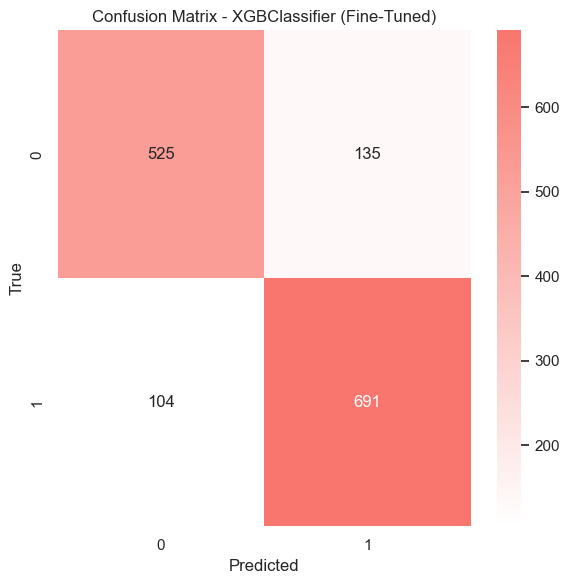


Relatório de Classificação:
              precision    recall  f1-score   support

           0     0.8347    0.7955    0.8146       660
           1     0.8366    0.8692    0.8526       795

    accuracy                         0.8357      1455
   macro avg     0.8356    0.8323    0.8336      1455
weighted avg     0.8357    0.8357    0.8353      1455



In [ ]:
# Definir o modelo com os melhores parâmetros
best_xgb = XGBClassifier(
    colsample_bytree = 1.0,
    learning_rate = 0.1,
    max_depth0 = 10,
    n_estimators = 200,
    subsample = 1.0
      )

# Treinar o modelo com todos os dados de treino
best_xgb.fit(X_train_full, y_train_full)

# Fazer previsões no conjunto de teste
y_pred = best_xgb.predict(X_test)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=2, output_dict=True)
labels = best_xgb.classes_

# Plot da matriz de confusão
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap=custom_cmap, xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - XGBClassifier (Fine-Tuned)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Relatório de classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, digits=4))


#### 5.6 Analise dos Resultados

##### **Métricas de Avaliação**

Para avaliar o desempenho dos modelos, foram analisadas as matrizes de confusão e os relatórios de classificação de cada um deles. Estes relatórios apresentam diversas métricas que permitem compreender a capacidade preditiva de cada modelo tanto de forma global como em relação a cada classe. Abaixo descrevem-se as principais métricas utilizadas:

**Precision:**
- Indica a proporção de previsões positivas que estavam corretas. Um valor elevado de precisão significa que o modelo comete poucos falsos positivos.

**Recall:**
- Mede a proporção de exemplos positivos corretamente identificados pelo modelo. Uma revocação alta indica que o modelo deteta bem a classe positiva, com poucos falsos negativos.

**F1-score:**
- É a média harmónica entre precision e recall. Serve como uma métrica de equilíbrio entre as duas anteriores, especialmente útil quando existe algum desequilíbrio entre classes.

**Support:**
- Representa o número de ocorrências reais de cada classe no conjunto de teste. Embora não seja uma métrica de desempenho, ajuda a contextualizar os valores obtidos.

**Accuracy:**
- Percentagem total de previsões corretas. Embora seja uma métrica geral intuitiva, pode ser enganadora em problemas com classes desequilibradas.

**Macro Avg / Weighted Avg:**

- Macro Average: média simples das métricas de todas as classes, tratando todas com o mesmo peso.

- Weighted Average: média ponderada pelo número de instâncias de cada classe, refletindo melhor o desempenho global quando há desequilíbrio de classes.

##### **Comparação de Modelos**

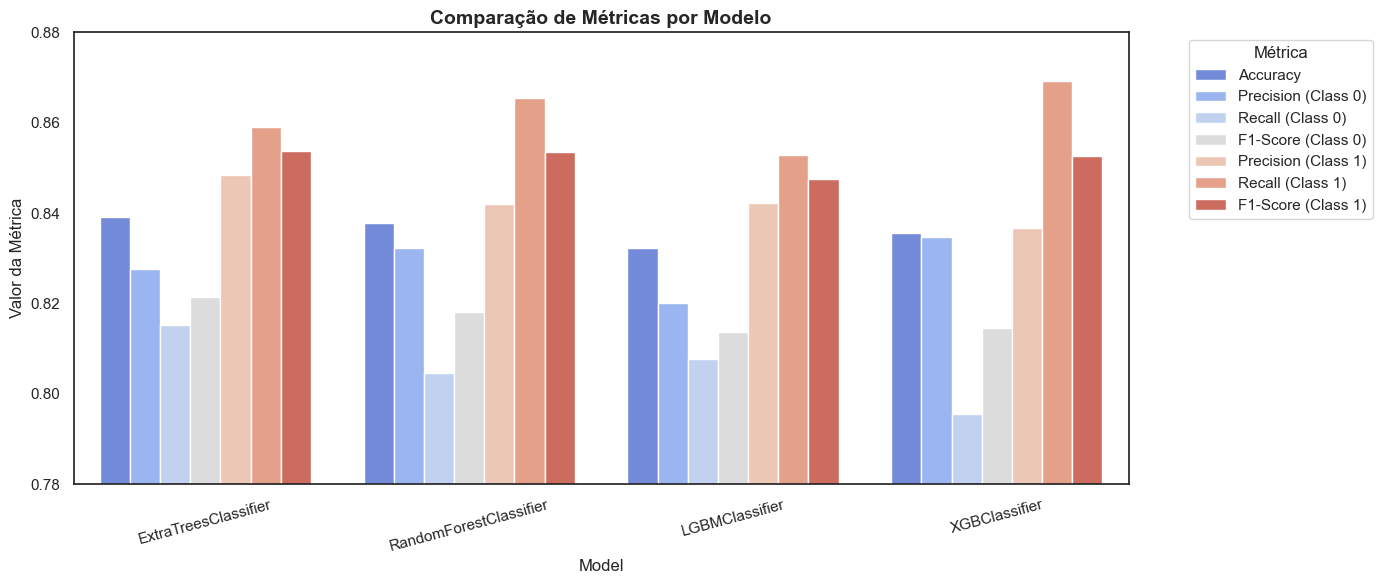

In [ ]:
# Dados das métricas
data = {
    'Model': ['ExtraTreesClassifier', 'RandomForestClassifier', 'LGBMClassifier', 'XGBClassifier'],
    'Accuracy': [0.8392, 0.8378, 0.8323, 0.8357],
    'Precision (Class 0)': [0.8277, 0.8323, 0.8200, 0.8347],
    'Recall (Class 0)': [0.8152, 0.8045, 0.8076, 0.7955],
    'F1-Score (Class 0)': [0.8214, 0.8182, 0.8137, 0.8146],
    'Precision (Class 1)': [0.8484, 0.8421, 0.8422, 0.8366],
    'Recall (Class 1)': [0.8591, 0.8654, 0.8528, 0.8692],
    'F1-Score (Class 1)': [0.8538, 0.8536, 0.8475, 0.8526],
}

df = pd.DataFrame(data)

df_long = df.melt(id_vars='Model', var_name='Métrica', value_name='Valor')

# Gráfico de barras agrupadas
plt.figure(figsize=(14, 6))
sns.barplot(data=df_long, x='Model', y='Valor', hue='Métrica', palette='coolwarm')
plt.title('Comparação de Métricas por Modelo', fontsize=14, weight='bold')
plt.ylabel('Valor da Métrica')
plt.ylim(0.78, 0.88)
plt.xticks(rotation=15)
plt.legend(title='Métrica', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


Após o ajuste dos hiperparâmetros, os quatro modelos foram avaliados com base no seu desempenho sobre o conjunto de teste. Todos eles apresentaram resultados muito próximos, com accuracy global entre 83,2% e 83,9%, o que evidencia a robustez dos classificadores escolhidos.

- **ExtraTreesClassifier** foi o modelo com melhor desempenho global, alcançando uma accuracy de 83,92%, com um F1-score de 0.8214 para a classe 0 e 0.8538 para a classe 1. Este modelo destacou-se por manter um bom equilíbrio entre precision e recall nas duas classes, sendo ligeiramente mais eficaz na detecção de compostos mutagénicos (classe 1), que é a classe de maior interesse neste contexto.

- **RandomForestClassifier** apresentou um desempenho muito próximo, com uma accuracy de 83,78% e um F1-score de 0.8182 (classe 0) e 0.8536 (classe 1). A ligeira diferença em relação ao ExtraTrees deve-se a uma taxa de falsos negativos um pouco superior na classe 0, ainda que tenha conseguido a maior recall para a classe 1 (86,54%).

- **XGBClassifier** obteve uma accuracy de 83,57%, destacando-se pela melhor precisão na classe 1 (0.8366) e um F1-score bastante competitivo (0.8526). No entanto, teve a maior taxa de falsos positivos para a classe 0, o que ligeiramente penalizou a sua taxa de recall.

- **LGBMClassifier**, embora muito consistente, apresenta-se com um desempenho ligeiramente inferior entre os quatro, com uma accuracy de 83,23%, F1-score de 0.8137 para a classe 0 e 0.8475 para a classe 1. Ainda assim, apresentou um comportamento equilibrado e estável, o que o torna uma opção válida em contextos com maior restrição de tempo computacional.

Globalmente, todos os modelos mostraram-se eficazes na predição da mutagenicidade, com ligeiras variações entre eles. O ExtraTreesClassifier e o RandomForestClassifier destacaram-se como as escolhas mais robustas e equilibradas, com uma vantagem minima para o **ExtraTreesClassifier** no conjunto de métricas.